# Prediction of Readmission for Diabetic Patients

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

In [2]:
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role                              
import matplotlib.pyplot as plt                   
from IPython.display import Image                 
from IPython.display import display               
from time import gmtime, strftime                 
from sagemaker.predictor import csv_serializer 

In [3]:
# Define IAM role
role = get_execution_role()
prefix = 'sagemaker/DEMO-xgboost-dm'
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'} # each region has its XGBoost container
my_region = boto3.session.Session().region_name # set the region of the instance
print("Success - the MySageMakerInstance is in the " + my_region + " region. You will use the " + containers[my_region] + " container for your SageMaker endpoint.")

Success - the MySageMakerInstance is in the us-east-1 region. You will use the 811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest container for your SageMaker endpoint.


In [4]:
# Get data from s3 bucket
bucket_name = 'data-cc'
s3 = boto3.resource('s3')
data_location = 's3://{}/{}'.format(bucket_name, 'diabetic_data.csv')

In [52]:
# Load data
data = pd.read_csv(data_location, header=0, na_values=['?'])

In [53]:
# Create a copy of the data
df = data.copy(deep=True)
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [54]:
df.shape

(101766, 50)

## Data Preprocessing

#### We want to narrow down to those patients who receive medicines/treatments for diabetes.

In [55]:
df = df[df.diabetesMed=='Yes']

In [56]:
df.shape

(78363, 50)

In [57]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78363 entries, 1 to 101764
Data columns (total 50 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   encounter_id              78363 non-null  int64 
 1   patient_nbr               78363 non-null  int64 
 2   race                      76492 non-null  object
 3   gender                    78363 non-null  object
 4   age                       78363 non-null  object
 5   weight                    2201 non-null   object
 6   admission_type_id         78363 non-null  int64 
 7   discharge_disposition_id  78363 non-null  int64 
 8   admission_source_id       78363 non-null  int64 
 9   time_in_hospital          78363 non-null  int64 
 10  payer_code                48949 non-null  object
 11  medical_specialty         40396 non-null  object
 12  num_lab_procedures        78363 non-null  int64 
 13  num_procedures            78363 non-null  int64 
 14  num_medications      

#### Separating 24 treatments into 2 categories 'insulin' and 'io' (stands for insulin + others) and create 1 column of Treatment

In [59]:
# Create a dataframe contains only treatment and encounter_id
treatments = df[['encounter_id','metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']].copy()

In [60]:
# Label values from treatment as 0 or 1. 0 means the medication is not prescribed.
# 1 means the medication is prescribed. 'Steady', 'Up', 'Down' are labled as 1
treatments=treatments.replace(['No','Steady','Up','Down'],[0,1,1,1])
treatments.set_index('encounter_id',inplace=True)

In [61]:
treatments.sum(axis=1).value_counts()

1    47314
2    21873
3     7778
4     1335
5       58
6        5
dtype: int64

Patients are given combination of 6 medications (at maximum). We will encode the treatment so that when the patient is given only insulin, we label the treatment as 'insulin'. When patient is given insulin and other medications, we label it as 'io' (insulin + others). We label 'others' otherwise.

#### When the value of Insulin is '1' , create the class "insulin" & "io" (insulin + others )

In [62]:
insulin1 = treatments[treatments['insulin']==1].sum(axis = 1).replace([1,2,3,4,5,6],['insulin','io','io','io','io','io'])

#### When the value of Insuin is '0' , create the class "others" & "no med"

In [63]:
insulin0 = treatments[treatments['insulin']==0].sum(axis=1).replace([0,1,2,3,4,5,6],['no med','other','other','other','other','other','other'])

#### Combine insulin1 and insulin0

In [64]:
# Combine insulin1 and insulin0
treatments=pd.concat([insulin1,insulin0])
treatments = pd.DataFrame({'treatments':treatments})

In [65]:
# Add treatments feature to the df dataframe
df=df.join(treatments,on='encounter_id') #setting index as encounter_id

In [66]:
# Now we have treatments as 1 column, we will remove the 24 treatments from df
df = df.drop(columns = ['metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone'])

In [67]:
# Remove 'other' class from treatments column
df = df[df.treatments!='other']

# Remove 'no med' class from treatments column
df = df[df.treatments!='no med']

In [68]:
# Remove any columns with id numbers.
# Patient_nbr and any id numbers such as admission_type, admission_source, and discharge_disposition will also be removed because they don't effect the predictions of readmission.
df = df.drop(columns = ['encounter_id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id'])

In [69]:
df.head()

,race,gender,age,weight,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,change,diabetesMed,readmitted,treatments
1,Caucasian,Female,[10-20),NaN,3,NaN,NaN,59,0,18,...,276,250.01,255,9,None,None,Ch,Yes,>30,insulin
3,Caucasian,Male,[30-40),NaN,2,NaN,NaN,44,1,16,...,8,250.43,403,7,None,None,Ch,Yes,NO,insulin
4,Caucasian,Male,[40-50),NaN,1,NaN,NaN,51,0,8,...,197,157,250,5,None,None,Ch,Yes,NO,io
5,Caucasian,Male,[50-60),NaN,3,NaN,NaN,31,6,16,...,414,411,250,9,None,None,No,Yes,>30,insulin
6,Caucasian,Male,[60-70),NaN,4,NaN,NaN,70,1,21,...,414,411,V45,7,None,None,Ch,Yes,NO,io


### Identify missing values

In [70]:
# Define a function to check variables with NaN
def nan_checker(df):
    '''
    The function checks for NaN
    Parameter df: dataframe
    Returns the dataframe of variables with NaN, their proportion of NaN, and dtype
    '''

  # Get the variables with NaN, their proportion of NaN and dtype
    df_nan = pd.DataFrame([[var, df[var].isna().sum() / df.shape[0], df[var].dtype]
                         for var in df.columns if df[var].isna().sum() > 0],
                        columns = ['var', 'proportion', 'dtype'])
  
  # Sort df_nan in descending order of the proportion of NaN
    df_nan = df_nan.sort_values(by = 'proportion', ascending = False)

    return df_nan

In [71]:
# Call the function nan_checker on df
df_nan = nan_checker(df)

# Print df_nan
df_nan.reset_index(drop=True)

,var,proportion,dtype
0,weight,0.983285,object
1,medical_specialty,0.481897,object
2,payer_code,0.340400,object
3,race,0.025486,object
4,diag_3,0.016421,object
5,diag_2,0.004726,object
6,diag_1,0.000165,object


There is no missing values that has numerical datatype. Variables 'weight', 'medical_specialty', and 'payer_code' have large proportions of NaN and they are object datatype, we will remove these three columns.

In [72]:
# Remove columns 'weight', 'medical_specialty', and 'payer_code'
df = df.drop(columns= ['weight', 'medical_specialty', 'payer_code'])

# Print the first 5 rows of df
df.head()

,race,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,change,diabetesMed,readmitted,treatments
1,Caucasian,Female,[10-20),3,59,0,18,0,0,0,276,250.01,255,9,None,None,Ch,Yes,>30,insulin
3,Caucasian,Male,[30-40),2,44,1,16,0,0,0,8,250.43,403,7,None,None,Ch,Yes,NO,insulin
4,Caucasian,Male,[40-50),1,51,0,8,0,0,0,197,157,250,5,None,None,Ch,Yes,NO,io
5,Caucasian,Male,[50-60),3,31,6,16,0,0,0,414,411,250,9,None,None,No,Yes,>30,insulin
6,Caucasian,Male,[60-70),4,70,1,21,0,0,0,414,411,V45,7,None,None,Ch,Yes,NO,io


In [73]:
# Print the unique dtypes of variables in df
pd.DataFrame(df.dtypes.unique(), columns = ['dtype'])

,dtype
0,object
1,int64


### Identify Categorical Variables that have object as dtype

In [74]:
# Define a function to check for variables with object as dtype
def cat_var_checker(df):
    """
    The function checks for categorical variables
    Parameter df: dataframe

    Returns the dataframe of categorical variables and their number of unique value
    """

  # Get the dataframe of categorical variables and their number of unique value
    df_cat = pd.DataFrame([[var, df[var].nunique(dropna=False)] 
                        for var in df.columns if df[var].dtype == 'object'],
                        columns = ['var', 'nunique'])
  
  # Sort df_cat in descending order of the number of unique value
    df_cat = df_cat.sort_values(by='nunique', ascending=False).reset_index(drop=True)

    return df_cat

In [75]:
# Call the function on df
df_cat = cat_var_checker(df)

# Print df_cat
df_cat

,var,nunique
0,diag_3,723
1,diag_2,666
2,diag_1,648
3,age,10
4,race,6
5,max_glu_serum,4
6,A1Cresult,4
7,readmitted,3
8,gender,2
9,change,2


#### Remove categorical features with large number of categories in df

In [76]:
# Remove diag_3, diag_2, diag_1 because they have large number of uniques in df.
# Another reason is they don't contribute to the outcome of the predictions of either readmitted or treatments.
df = df.drop(columns = ['diag_1', 'diag_2', 'diag_3'])

In [77]:
# Imputing NaN with mode
df['race'].fillna(df['race'].mode()[0], inplace=True)

## Exploratory Data Analysis

In [78]:
import seaborn as sns
sns.set_style('whitegrid')

Text(0.5, 1.0, 'Count of Readmission')

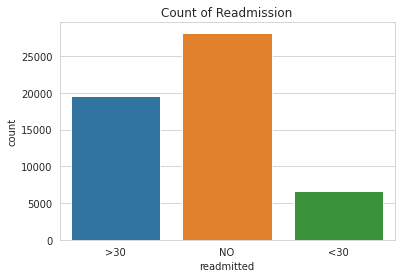

In [79]:
# Count of all three classes for readmission
sns.countplot(df['readmitted']).set_title('Count of Readmission')

Text(0.5, 1.0, 'Count of Treatments')

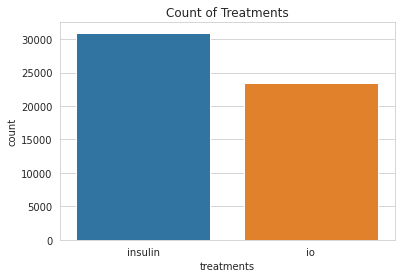

In [80]:
# Count of all three types of treatment i.e. insuline, io and other
sns.countplot(df['treatments']).set_title('Count of Treatments')

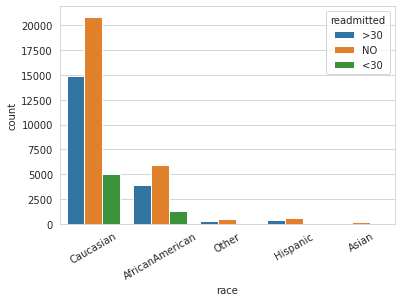

In [81]:
#Race 
ax = sns.countplot(x = 'race', data = df, hue="readmitted")
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax

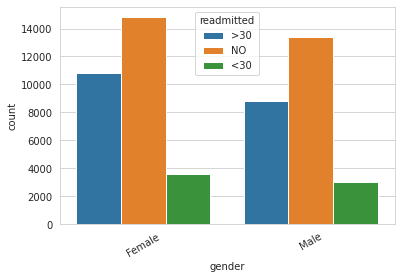

In [82]:
#Gender 
ax = sns.countplot(x = 'gender', data = df, hue="readmitted")
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax

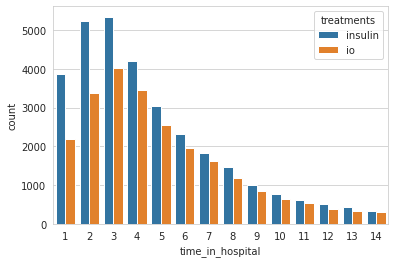

In [83]:
#Time_in_hospital vs Treatment
#to check how many people get readmitted after being discharged for first time
sns.countplot(x="time_in_hospital", hue= 'treatments', data=df)

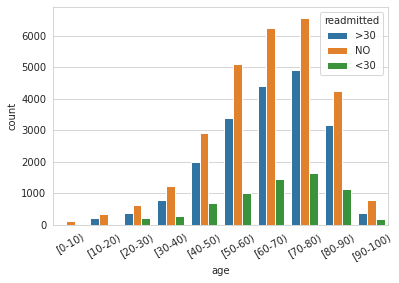

In [84]:
#Readmitted vs age
#Which age group has maximum readmitted entries
ax = sns.countplot(x = 'age', data = df,hue="readmitted", order = ['[0-10)', '[10-20)', '[20-30)', '[30-40)','[40-50)','[50-60)','[60-70)','[70-80)','[80-90)','[90-100)'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax

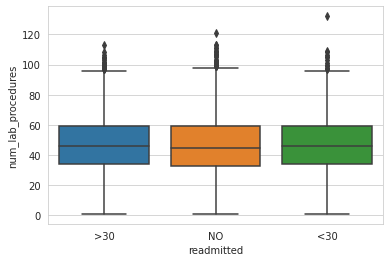

In [85]:
#Num_lab_procedures vs Readmitted
ax = sns.boxplot(y = 'num_lab_procedures', data = df, x = "readmitted")

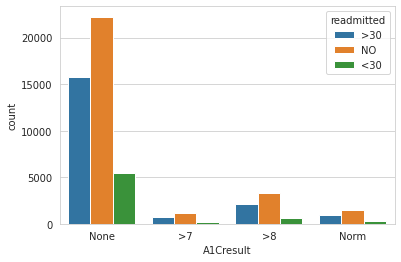

In [86]:
#Alcohol vs Readmission
#What level of alcohol causes most no. of people to be readmitted
ax = sns.countplot(x = 'A1Cresult', data = df, hue = 'readmitted')

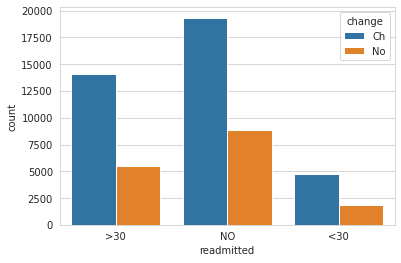

In [87]:
#Change in medication vs Readmission
ax = sns.countplot(hue = 'change', data = df, x = 'readmitted')

## Feature Engineering

#### The following function provides the following label/custom categories for age: [0-10): 1 [10-20): 2 [20-30): 3 [30-40): 4 [40-50): 5 [50-60): 6 [60-70): 7 [70-80): 8 [80-90): 9 [90-100): 10

In [88]:
# encoding age columns with 10 categories
labels = data['age'].astype('category').cat.categories.tolist()
replace_age = {'age' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

# Display the categories
replace_age

{'age': {'[0-10)': 1,
  '[10-20)': 2,
  '[20-30)': 3,
  '[30-40)': 4,
  '[40-50)': 5,
  '[50-60)': 6,
  '[60-70)': 7,
  '[70-80)': 8,
  '[80-90)': 9,
  '[90-100)': 10}}

In [89]:
# Replace each age category with a custom label
df = df.replace(replace_age)

# Display the first 5 instances
df.head()

,race,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,change,diabetesMed,readmitted,treatments
1,Caucasian,Female,2,3,59,0,18,0,0,0,9,None,None,Ch,Yes,>30,insulin
3,Caucasian,Male,4,2,44,1,16,0,0,0,7,None,None,Ch,Yes,NO,insulin
4,Caucasian,Male,5,1,51,0,8,0,0,0,5,None,None,Ch,Yes,NO,io
5,Caucasian,Male,6,3,31,6,16,0,0,0,9,None,None,No,Yes,>30,insulin
6,Caucasian,Male,7,4,70,1,21,0,0,0,7,None,None,Ch,Yes,NO,io


#### Because we want to predict readmission within 30 days, we will group NO and >30 days as 1 group, label as 0, and group patients readmitted within 30 days as 1 group, label as 1 for readmitted.

In [90]:
# Encoding column 'readmitted'
df['readmitted'] = df['readmitted'].replace(['NO', '>30', '<30'], [0,0,1])

## Predicting Readmission

In [91]:
target_readmitted = 'readmitted'

#### Encoding the categorical features using pandas.get_dummies

In [92]:
# Check categorical variables again
# Call the function on df
df_cat = cat_var_checker(df)

# Print df_cat
df_cat

,var,nunique
0,race,5
1,max_glu_serum,4
2,A1Cresult,4
3,gender,2
4,change,2
5,treatments,2
6,diabetesMed,1


In [93]:
# One-hot-encode the categorical features in the combined data
df = pd.get_dummies(df, columns = np.setdiff1d(np.intersect1d(df.columns, df_cat['var']), [target_readmitted]))

#### Encoding the Categorical Target using sklearn.LabelEncoder

In [94]:
from sklearn.preprocessing import LabelEncoder

# The LabelEncoder
le = LabelEncoder()

# Encode the categorical target in the combined data
df[target_readmitted] = le.fit_transform(df[target_readmitted].astype(str))

#### Dividing df into training and testing sets

In [95]:
from sklearn.model_selection import train_test_split
# Divide the training data into training (80%) and test (20%) using sklearn train_test_split with random_state=42 and stratify
df_train, df_test = train_test_split(df, train_size = 0.8, random_state = 42, stratify = df[target_readmitted])

# Reset the index
df_train, df_test = df_train.reset_index(drop=True), df_test.reset_index(drop=True)

#### Dividing df_train into training and validation sets

In [96]:
from sklearn.model_selection import train_test_split
# Divide the training data into training (80%) and test (20%) using sklearn train_test_split with random_state=42 and stratify
df_train, df_valid = train_test_split(df_train, train_size = 0.8, random_state = 42, stratify = df_train[target_readmitted])

# Reset the index
df_train, df_valid = df_train.reset_index(drop=True), df_valid.reset_index(drop=True)

In [97]:
df_train.shape

(34804, 30)

In [98]:
df_valid.shape

(8702, 30)

In [99]:
df_test.shape

(10877, 30)

#### Getting the feature matrix and target vector

In [100]:
# Get the name of features
features = np.setdiff1d(df.columns, [target_readmitted])

In [101]:
# Get the feature matrix
X_train = df_train[features].to_numpy()
X_valid = df_valid[features].to_numpy()
X_test = df_test[features].to_numpy()

# Get the target vector
y_train = df_train[target_readmitted].astype(int).to_numpy()
y_valid = df_valid[target_readmitted].astype(int).to_numpy()

### Scaling the data

In [102]:
# Standardize the data using sklearn StandardScaler
from sklearn.preprocessing import StandardScaler

# The StandardScaler
ss = StandardScaler()

# Standardize the training data
X_train = ss.fit_transform(X_train)

# Standardize the validation data
X_valid = ss.transform(X_valid)

# Standardize the testing data
X_test = ss.transform(X_test)

### Hyperparameter Tuning and Model Selection

The models include Logistic Regression, Random Forest, and Gradient Boosting

In [103]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

models = {'lr': LogisticRegression(class_weight='balanced', random_state=42),
          'rfc': RandomForestClassifier(class_weight='balanced', random_state=42),
          'hgbc': HistGradientBoostingClassifier(random_state=42)}

#### Create pipelines

In [104]:
from sklearn.pipeline import Pipeline

pipes = {}

for acronym, model in models.items():
    pipes[acronym] = Pipeline([('model', model)])

In [105]:
# Predefined split cross validator
from sklearn.model_selection import PredefinedSplit

# Combine the feature matrix in the training and validation data
X_train_valid = np.vstack((X_train, X_valid))

# Combine the target vector in the training and validation data
y_train_valid = np.append(y_train, y_valid)

# Get the indices of training and validation data
train_valid_idxs = np.append(np.full(X_train.shape[0], -1), np.full(X_valid.shape[0], 0))

# The PredefinedSplit
ps = PredefinedSplit(train_valid_idxs)

In [106]:
# Create dictionary of parameter grids
param_grids = {}

The parameter grids for logistic regression

In [107]:
# The grid for C
C_grids = [10**i for i in range(-6,3)]

# The grids for tol
tol_grids = [10 ** i for i in range(-6, -1)]

# The grid for penalty
penalty_grids = ['l1', 'l2']

# Update param_grids
param_grids['lr'] = [{'model__C': C_grids,
                      'model__tol': tol_grids,
                      'model__penalty': penalty_grids}]

The parameter grids for random forest

In [108]:
# The grids for min_samples_split
min_samples_split_grids = [2, 20, 100]

# The grids for min_samples_leaf
min_samples_leaf_grids = [1, 20, 100]

# Update param_grids
param_grids['rfc'] = [{'model__min_samples_split': min_samples_split_grids,
                       'model__min_samples_leaf': min_samples_leaf_grids}]

The parameter grids for gradient boosting

In [109]:
# The grids for learning_rate
learning_rate_grids = [10 ** i for i in range(-6, 2)]

# The grids for max_iter
max_iter_grids = [50, 100, 500]

# The grids for min_samples_leaf
min_samples_leaf_grids = [1, 20, 100]

# Update param_grids
param_grids['hgbc'] = [{'model__learning_rate': learning_rate_grids,
                        'model__min_samples_leaf': min_samples_leaf_grids}]

In [111]:
import os

# Make directory
directory = 'cv_result'
abspath = 'results/'
path = os.path.join(abspath, directory)
if not os.path.exists(path):
    os.makedirs(path)

### Hyperparameter Tuning

In [112]:
from sklearn.model_selection import GridSearchCV

# The list of [best_score_, best_params_, best_estimator_] obtained by GridSearchCV
best_score_param_estimator_gs = []

for acronym in pipes.keys():
    # GridSearchCV
    gs = GridSearchCV(estimator=pipes[acronym],
                      param_grid=param_grids[acronym],
                      scoring='f1_micro',
                      n_jobs=-1,
                      cv=ps,
                      return_train_score=True)
        
    # Fit the pipeline
    gs = gs.fit(X_train_valid, y_train_valid)
    
    # Update best_score_param_estimator_gs
    best_score_param_estimator_gs.append([gs.best_score_, gs.best_params_, gs.best_estimator_])
    
    # Sort cv_results in ascending order of 'rank_test_score' and 'std_test_score'
    cv_results = pd.DataFrame.from_dict(gs.cv_results_).sort_values(by=['rank_test_score', 'std_test_score'])
    
    # Get the important columns in cv_results
    important_columns = ['rank_test_score',
                         'mean_test_score', 
                         'std_test_score', 
                         'mean_train_score', 
                         'std_train_score',
                         'mean_fit_time', 
                         'std_fit_time',                        
                         'mean_score_time', 
                         'std_score_time']
    
    # Move the important columns ahead
    cv_results = cv_results[important_columns + sorted(list(set(cv_results.columns) - set(important_columns)))]
    
    # Write cv_results file
    cv_results.to_csv(path_or_buf=abspath + 'cv_result/' + acronym + '.csv', index=False)

### Model Selection

In [113]:
# Sort best_score_param_estimator_gs in descending order of the best_score_
best_score_param_estimator_gs = sorted(best_score_param_estimator_gs, key=lambda x : x[0], reverse=True)

# Print best_score_param_estimator_gs
pd.DataFrame(best_score_param_estimator_gs, columns=['best_score', 'best_param', 'best_estimator'])

,best_score,best_param,best_estimator
0,0.878878,"{'model__min_samples_leaf': 1, 'model__min_sam...","((DecisionTreeClassifier(ccp_alpha=0.0, class_..."
1,0.878649,"{'model__learning_rate': 1e-06, 'model__min_sa...",(HistGradientBoostingClassifier(l2_regularizat...
2,0.672259,"{'model__C': 0.1, 'model__penalty': 'l2', 'mod...","(LogisticRegression(C=0.1, class_weight='balan..."


Random Forest Classifier has the highest score 87.89%

### Deep Neural Network¶

In [121]:
# Make directory
import os
directory = 'model'
abspath = 'DNNResult/'.format(bucket_name)
path = os.path.join(abspath, directory)
if not os.path.exists(path):
    os.makedirs(path)

In [115]:
#%tensorflow_version 2.x 
import tensorflow as tf
from tensorflow import keras

In [116]:
# The random seed
random_seed = 42

# Set random seed in tensorflow
# tf.random.set_seed(random_seed)

# Set random seed in numpy
import numpy as np
np.random.seed(random_seed)

In [117]:
# A sequential dnn
model = keras.models.Sequential()

# Add the input layer
model.add(keras.layers.Flatten(input_shape = [X_train.shape[1]]))

# Add three hidden layers
model.add(keras.layers.Dense(50, activation="relu"))
model.add(keras.layers.Dense(50, activation="relu"))
model.add(keras.layers.Dense(50, activation="relu"))


# Add the output layer
model.add(keras.layers.Dense(1, activation="sigmoid"))

# The model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 29)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                1500      
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total params: 6,651
Trainable params: 6,651
Non-trainable params: 0
_________________________________________________________________


In [118]:
# Compile the model
model.compile(optimizer=keras.optimizers.SGD(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Setting callbacks

In [123]:
# ModelCheckpoint callback
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(
    filepath=abspath + "model/model.h5",
    save_best_only=True)

# EarlyStopping callback
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True)

### Train, evaluate, and save the best model

In [124]:
# Train, evaluate and save the best model
history = model.fit(X_train, y_train, epochs=150, validation_data=(X_valid, y_valid),batch_size=150,callbacks=[model_checkpoint_cb, early_stopping_cb])


Train on 34804 samples, validate on 8702 samples
Epoch 1/150
34804/34804 [==============================] - 1s 33us/sample - loss: 0.3724 - acc: 0.8786 - val_loss: 0.3698 - val_acc: 0.8786
Epoch 2/150
34804/34804 [==============================] - 1s 24us/sample - loss: 0.3680 - acc: 0.8786 - val_loss: 0.3663 - val_acc: 0.8788
Epoch 3/150
34804/34804 [==============================] - 1s 24us/sample - loss: 0.3651 - acc: 0.8786 - val_loss: 0.3638 - val_acc: 0.8788
Epoch 4/150
34804/34804 [==============================] - 1s 25us/sample - loss: 0.3631 - acc: 0.8786 - val_loss: 0.3621 - val_acc: 0.8791
Epoch 5/150
34804/34804 [==============================] - 1s 24us/sample - loss: 0.3618 - acc: 0.8787 - val_loss: 0.3609 - val_acc: 0.8790
Epoch 6/150
34804/34804 [==============================] - 1s 26us/sample - loss: 0.3608 - acc: 0.8787 - val_loss: 0.3601 - val_acc: 0.8788
Epoch 7/150
34804/34804 [==============================] - 1s 24us/sample - loss: 0.3601 - acc: 0.8788 - val_lo

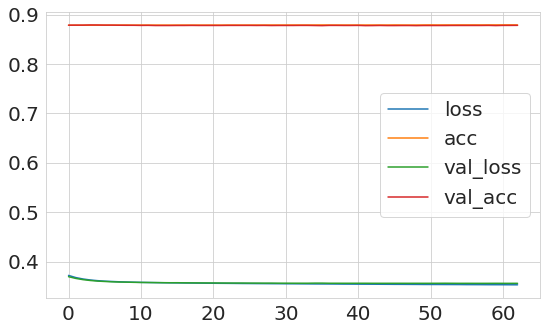

In [125]:
# Plot the learning curve
import matplotlib.pyplot as plt
%matplotlib inline 

# Set matplotlib sizes
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rc('figure', titlesize=20)

# Create a figure
pd.DataFrame(history.history).plot(figsize=(8, 5))

# Save and show the figure
plt.tight_layout()
plt.savefig(abspath + 'learning_curve.pdf')
plt.show()

### Perform the model on the test set

In [126]:
# Load the model
model = keras.models.load_model(abspath + "model/model.h5")

In [127]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, df_test[target_readmitted].astype(int).to_numpy(), verbose=0)

In [128]:
# Print the accuracy
print('test_accuracy:', accuracy)

test_accuracy: 0.87855107


## Comparing the models

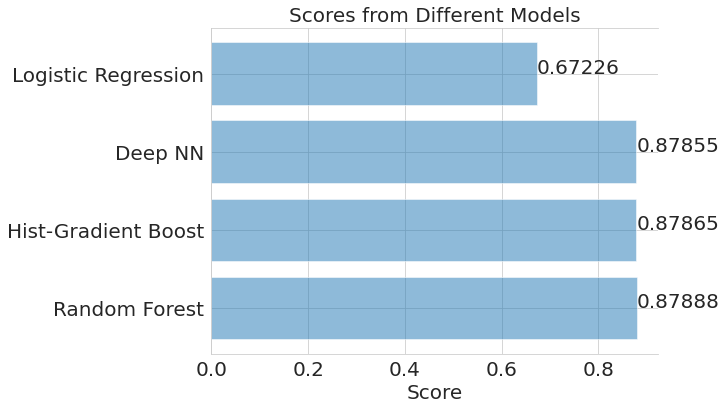

<Figure size 432x288 with 0 Axes>

In [130]:
# Create 2 lists for x and y axis
models = ['Random Forest', 'Hist-Gradient Boost', 'Deep NN', 'Logistic Regression']
scores = [round(best_score_param_estimator_gs[0][0],5), round(best_score_param_estimator_gs[1][0],5), round(accuracy,5), round(best_score_param_estimator_gs[2][0],5)]

# Plot the bar chart for models' scores
fig, ax = plt.subplots(figsize=(8, 6))
plt.barh(models, scores, align='center', alpha=0.5)
plt.xlabel('Score')
plt.title('Scores from Different Models')
#ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Show values on the bar chart
for index, value in enumerate(scores):
    plt.text(value, index, str(value))
plt.show()
plt.savefig('Scores from models.png')

#### Generate Prediction File

In [131]:
# Get the best_score, best_param and best_estimator obtained by GridSearchCV
best_score_gs, best_param_gs, best_estimator_gs = best_score_param_estimator_gs[0]

In [132]:
# Get the prediction on the testing data using best_model
y_test_pred = best_estimator_gs.predict(X_test)

# Transform y_test_pred back to the original class
y_test_pred = le.inverse_transform(y_test_pred)

# Get the submission dataframe
df_submit = pd.DataFrame(np.hstack((np.arange(1, y_test_pred.shape[0] + 1).reshape(-1, 1), y_test_pred.reshape(-1, 1))),
                         columns=['Id', 'Label'])                                                                                      

# Generate the submission file
df_submit.to_csv('submission.csv', index=False)